# Training data augmentation (character-level)

In [62]:
! pip install imgaug

In [63]:
import os
import random
import numpy as np
import imageio.v2 as imageio
import imgaug as ia
import imgaug.augmenters as iaa
%matplotlib inline

## Load and show a random image

In [209]:
def pad_images(images):
    max_width = max(img.shape[1] for img in images)
    max_height = max(img.shape[0] for img in images)

    padded_images = []
    seq = iaa.Sequential([iaa.PadToFixedSize(width=max_width, height=max_height, position="center", pad_cval=255)])

    for img in images:
        padded_img = seq.augment_image(img)
        padded_images.append(padded_img)

    return padded_images


In [216]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import numpy as np

def show_images(images):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')
    ax.imshow(np.hstack(images), cmap='gray', alpha=1.0)
    ax.set_alpha(0.0)
    plt.show()

Random character: Alef


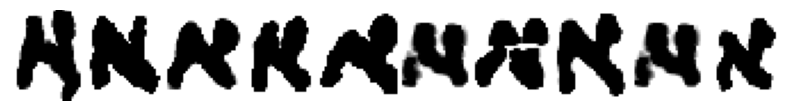

In [230]:
# choose a random directory and file
path = '../data/preprocessed_images/symbols'
# random_dir = random.choice(os.listdir(path))
random_dir = 'Alef'
print("Random character:", random_dir)

img_list0 = []

for _ in range(10):
    random_file = random.choice(os.listdir(os.path.join(path, random_dir)))
    img = imageio.imread(os.path.join(path, random_dir, random_file))
    img_list0.append(img)

# read and show image
# img = imageio.imread(os.path.join(path, random_dir, random_file))
# img_list = [img, img, img, img, img]
# ia.imshow(img)

img_list = pad_images(img_list0)
show_images(img_list)

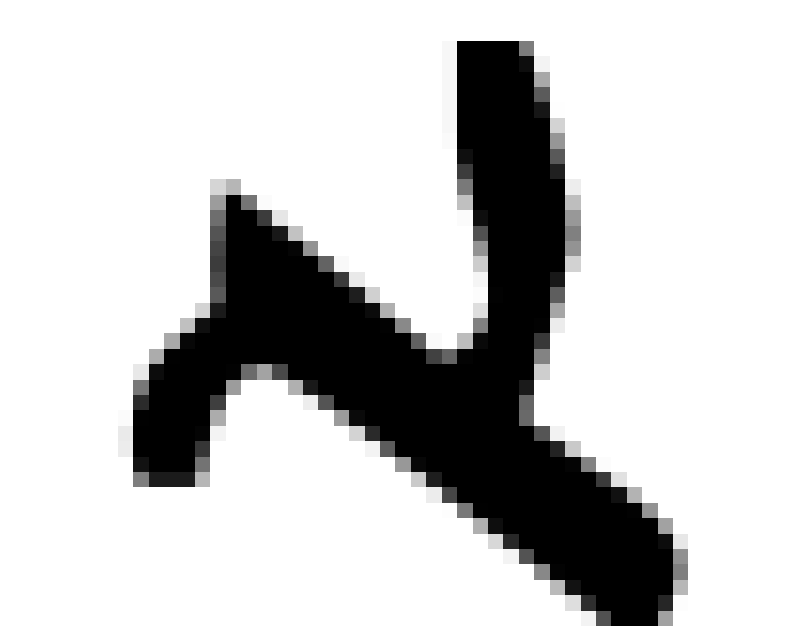

In [228]:
from generate_data.data_generator import create_image

img = create_image(random_dir, (50, 40))

# img_list2 = pad_images(img_list2)
# show_images(img_list2)
show_images([img])

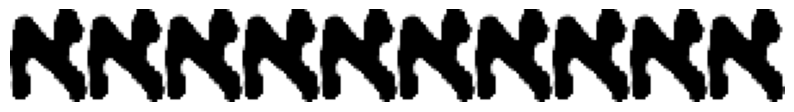

In [238]:
# random sample from img_list
# img = random.choice(img_list0)
img = img_list0[-3]
# create a list with img 10 times
img_list = [img for _ in range(10)]
# ia.imshow(np.hstack(img_list))
show_images(img_list)

## Rotation + shear

Augmented batch:


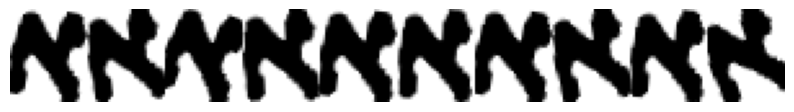

In [240]:
ia.seed(4)

rotate = iaa.Affine(rotate=(-15, 15), shear=(-15, 15), mode='constant', cval=255)

images_aug = rotate(images=img_list)
print("Augmented batch:")
# ia.imshow(np.hstack(images_aug))
show_images(images_aug)

## Gaussian blur

Augmented batch:


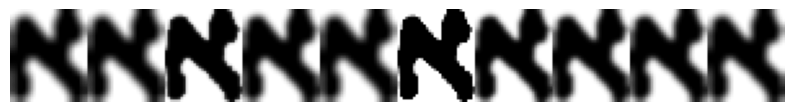

In [242]:
blur = iaa.GaussianBlur(sigma=(0, 2.0))

images_aug = blur(images=img_list)
print("Augmented batch:")
# ia.imshow(np.hstack(images_aug))
show_images(images_aug)

## Dropout pixels
- note: I think this is not a good augmentation for this task. It is just to show how it works.
- salt and pepper noise would be a better choice

Augmented batch:


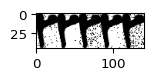

In [67]:
dropout = iaa.Dropout(p=(0, 0.2))

images_aug = dropout(images=img_list)
print("Augmented batch:")
# ia.imshow(np.hstack(images_aug))
show_images(images_aug)

## Salt and pepper noise
- note: the images are very small, so the grains appear very large

Augmented batch:


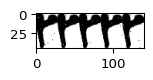

In [68]:
aug = iaa.SaltAndPepper(p=(0, 0.01))

images_aug = aug(images=img_list)
print("Augmented batch:")
ia.imshow(np.hstack(images_aug))

## Salt noise
- maybe use it for the final text image

Augmented batch:


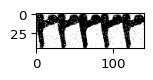

In [69]:
aug = iaa.Salt(p=(0, 0.1))

images_aug = aug(images=img_list)
print("Augmented batch:")
ia.imshow(np.hstack(images_aug))

## Cutout
- we can use it to fill random areas of the image with white pixels (as small boxes)

Augmented batch:


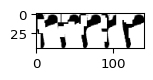

In [70]:
aug = iaa.Cutout(nb_iterations=5, size=0.3, squared=False,
                 fill_mode="constant", cval=255)

images_aug = aug(images=img_list)
print("Augmented batch:")
ia.imshow(np.hstack(images_aug))

## Resize (crop and pad to keep the original size)

Augmented batch:


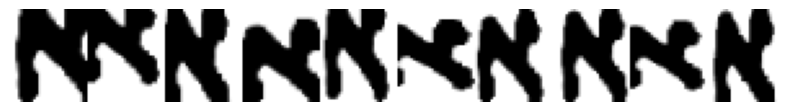

In [244]:
aug = iaa.KeepSizeByResize(iaa.CropAndPad(percent=(-0.2, 0.2), pad_mode='constant', pad_cval=255))

images_aug = aug(images=img_list)
print("Augmented batch:")
# ia.imshow(np.hstack(images_aug))
show_images(images_aug)

Augmented batch:


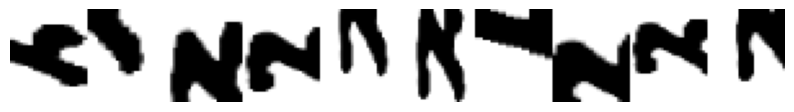

In [258]:
aug = iaa.KeepSizeByResize(
                iaa.CropAndPad(percent=(-0.5, 0.5), pad_mode='constant',
                               pad_cval=255))

images_aug = aug(images=img_list)
print("Augmented batch:")
# ia.imshow(np.hstack(images_aug))
show_images(images_aug)

## Elastic transformation

Augmented batch:


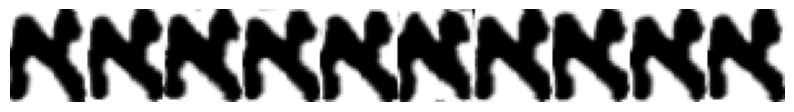

In [246]:
aug = iaa.ElasticTransformation(alpha=(0,20), sigma=(4,6))

# pad the images to avoid black borders after augmentation
pad = iaa.size.Pad(px=1, pad_mode='constant', pad_cval=255)
images_pad = pad(images=img_list)

# elastic transformation
images_aug = aug(images=images_pad)

# crop the images to the original size
crop = iaa.size.Crop(px=1)
images_aug = crop(images=images_aug)

print("Augmented batch:")
# ia.imshow(np.hstack(images_aug))
show_images(images_aug)

Original batch:


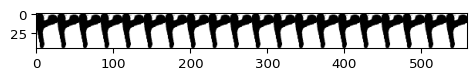

In [73]:
img_list = [img for _ in range(20)]

# show original batch (20 times the same image)
print("Original batch:")
ia.imshow(np.hstack(img_list))

## Add diagonal cuts through the letter

In [270]:
import cv2

def add_diagonal_cuts(images, random_state, parents, hooks):
    """Add diagonal white cuts through the letter"""
    augm_imgs = []

    for image in images:
        number_of_cuts = random_state.randint(0, 4)

        for _ in range(number_of_cuts):
            # Choose a random point on the left margin of the image
            y_left = random_state.randint(0, image.shape[1])

            mid_y = image.shape[1] // 2

            # Choose a random point on the right margin of the image
            # The point must be on the opposite side of the image to
            #  simulate a diagonal cut
            if y_left < mid_y:
                y_right = random_state.randint(mid_y, image.shape[1])
            else:
                y_right = random_state.randint(0, mid_y)

            # Define the points to draw the line
            point_left = (0, y_left)
            point_right = (image.shape[0], y_right)

            # Choose a random thickness for the line
            thickness = random_state.randint(1, 3)

            # Draw the line on the mask
            image = cv2.line(
                image, point_left, point_right, (255, 255, 255), thickness)

        augm_imgs.append(image)

    return augm_imgs

Augmented batch:


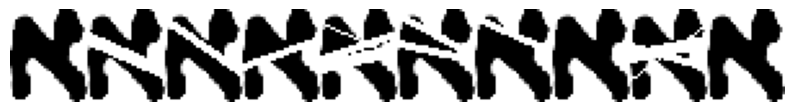

In [268]:
# cuts = iaa.Sometimes(
#             0.5,
#             iaa.Lambda(add_diagonal_cuts)
#         )

cuts = iaa.Lambda(add_diagonal_cuts)

images_aug = np.asarray(img_list)
images_aug = cuts(images=images_aug)
print("Augmented batch:")
# ia.imshow(np.hstack(images_aug))
show_images(images_aug)

# Let's combine some augmentations

In [265]:
rotation = (-15, 15)
shear = (-15, 15)
gauss_blur_sigma = (0, 2.0)
crop = (-0.2, 0.2)
elastic_alpha = (0, 20)
elastic_sigma = (4, 6)

# for each parameter, select a random value from the range
# rotation = random.uniform(*rotation)
# shear = random.uniform(*shear)
# gauss_blur_sigma = random.uniform(*gauss_blur_sigma)
# crop = random.uniform(*crop)
# elastic_alpha = random.uniform(*elastic_alpha)
# elastic_sigma = random.uniform(*elastic_sigma)

# print("Rotation:", rotation)
# print("Shear:", shear)
# print("Gaussian blur sigma:", gauss_blur_sigma)
# print("Crop:", crop)
# print("Elastic alpha:", elastic_alpha)
# print("Elastic sigma:", elastic_sigma)


Augmented batch:


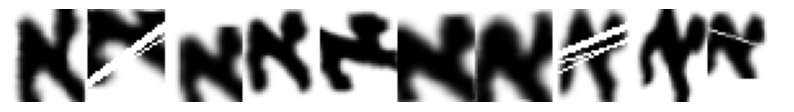

In [271]:
aug = iaa.Sequential([
    iaa.Affine(rotate=rotation, shear=shear, mode='constant', cval=255),
    iaa.GaussianBlur(sigma=gauss_blur_sigma),
    iaa.KeepSizeByResize(
        iaa.CropAndPad(percent=crop, pad_mode='constant', pad_cval=255)),
    iaa.Pad(px=2, pad_mode='constant', pad_cval=255),
    iaa.ElasticTransformation(alpha=elastic_alpha, sigma=elastic_sigma),
    iaa.size.Crop(px=2),
    iaa.Sometimes(
        0.5,
        iaa.Lambda(add_diagonal_cuts)
    ),
    iaa.Sometimes(
        0.1,
        iaa.KeepSizeByResize(
            iaa.CropAndPad(percent=(-0.5, 0.5), pad_mode='constant',
                           pad_cval=255))
    )
])

aug_image = aug(images=img_list)
print("Augmented batch:")
# ia.imshow(np.hstack(aug_image))
show_images(aug_image)